In [26]:
from preprocessor import Preprocessor
from batch_generator import BatchGenerator
from keras.optimizers import Adam
import keras
import modelling
import importlib

In [2]:
train_generator = BatchGenerator(64, 64, mode='train')
test_generator = BatchGenerator(64, 64, mode='test')

In [3]:
train_generator[0][0][0].shape, train_generator[0][0][1].shape

((128, 20), (128, 20))

In [138]:
importlib.reload(modelling)

<module 'modelling' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\modelling.py'>

In [139]:
# model = Mothership_v1(15, [102, 42], 16, [102, 102, 42], 10, [2, 2], [2, 2, 2])
model = modelling.Mothership_v1(20, [], 20, [], 10, [], [])

In [159]:
model.compile(Adam(lr=.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [160]:
model.fit_generator(train_generator, epochs=1)

Epoch 1/1


257/695 [==========>...................] - ETA: 16:24 - loss: 0.5151 - acc: 0.75 - ETA: 4:16 - loss: 0.5318 - acc: 0.7305 - ETA: 2:58 - loss: 0.5210 - acc: 0.743 - ETA: 2:03 - loss: 0.5295 - acc: 0.734 - ETA: 1:29 - loss: 0.5283 - acc: 0.735 - ETA: 1:25 - loss: 0.5291 - acc: 0.734 - ETA: 1:10 - loss: 0.5328 - acc: 0.731 - ETA: 1:09 - loss: 0.5306 - acc: 0.734 - ETA: 1:08 - loss: 0.5319 - acc: 0.732 - ETA: 1:05 - loss: 0.5280 - acc: 0.736 - ETA: 1:04 - loss: 0.5271 - acc: 0.736 - ETA: 1:03 - loss: 0.5261 - acc: 0.737 - ETA: 1:02 - loss: 0.5249 - acc: 0.739 - ETA: 1:01 - loss: 0.5253 - acc: 0.738 - ETA: 1:01 - loss: 0.5283 - acc: 0.736 - ETA: 1:01 - loss: 0.5287 - acc: 0.735 - ETA: 1:00 - loss: 0.5291 - acc: 0.734 - ETA: 59s - loss: 0.5318 - acc: 0.731 - ETA: 58s - loss: 0.5331 - acc: 0.73 - ETA: 58s - loss: 0.5333 - acc: 0.73 - ETA: 57s - loss: 0.5312 - acc: 0.73 - ETA: 57s - loss: 0.5301 - acc: 0.73 - ETA: 56s - loss: 0.5302 - acc: 0.73 - ETA: 56s - loss: 0.5298 - acc: 0.73 - ETA: 55s 

497/695 [====================>.........] - ETA: 30s - loss: 0.5232 - acc: 0.74 - ETA: 30s - loss: 0.5232 - acc: 0.74 - ETA: 30s - loss: 0.5232 - acc: 0.74 - ETA: 30s - loss: 0.5233 - acc: 0.74 - ETA: 30s - loss: 0.5234 - acc: 0.74 - ETA: 30s - loss: 0.5235 - acc: 0.74 - ETA: 30s - loss: 0.5233 - acc: 0.74 - ETA: 30s - loss: 0.5237 - acc: 0.74 - ETA: 30s - loss: 0.5237 - acc: 0.74 - ETA: 30s - loss: 0.5236 - acc: 0.74 - ETA: 30s - loss: 0.5234 - acc: 0.74 - ETA: 29s - loss: 0.5235 - acc: 0.74 - ETA: 29s - loss: 0.5235 - acc: 0.74 - ETA: 29s - loss: 0.5235 - acc: 0.74 - ETA: 29s - loss: 0.5237 - acc: 0.74 - ETA: 29s - loss: 0.5236 - acc: 0.74 - ETA: 29s - loss: 0.5236 - acc: 0.74 - ETA: 29s - loss: 0.5238 - acc: 0.74 - ETA: 29s - loss: 0.5238 - acc: 0.74 - ETA: 29s - loss: 0.5239 - acc: 0.74 - ETA: 29s - loss: 0.5237 - acc: 0.74 - ETA: 29s - loss: 0.5237 - acc: 0.74 - ETA: 29s - loss: 0.5238 - acc: 0.74 - ETA: 29s - loss: 0.5240 - acc: 0.74 - ETA: 29s - loss: 0.5241 - acc: 0.74 - ETA: 29

695/695 [==============================] - ETA: 13s - loss: 0.5223 - acc: 0.74 - ETA: 13s - loss: 0.5224 - acc: 0.74 - ETA: 13s - loss: 0.5224 - acc: 0.74 - ETA: 13s - loss: 0.5223 - acc: 0.74 - ETA: 13s - loss: 0.5223 - acc: 0.74 - ETA: 13s - loss: 0.5224 - acc: 0.74 - ETA: 13s - loss: 0.5224 - acc: 0.74 - ETA: 13s - loss: 0.5225 - acc: 0.74 - ETA: 13s - loss: 0.5224 - acc: 0.74 - ETA: 13s - loss: 0.5225 - acc: 0.74 - ETA: 13s - loss: 0.5225 - acc: 0.74 - ETA: 13s - loss: 0.5226 - acc: 0.74 - ETA: 13s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5224 - acc: 0.74 - ETA: 12s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5225 - acc: 0.74 - ETA: 12s - loss: 0.5224 - acc: 0.74 - ETA: 12s - loss: 0.5224 - acc: 0.74 - ETA: 12s - loss: 0.5223 - acc: 0.74 - ETA: 12s - loss: 0.5223 - acc: 0.74 - ETA: 12s - loss: 0.5223 - acc: 0.74 - ETA: 12

In [161]:
model.evaluate_generator(test_generator)

[0.563234285439974, 0.7108410493827161]

In [61]:
import sys

In [62]:
sys.path.append('../nikita')

In [63]:
from evaluating import permutation_importance

In [64]:
import pickle

In [65]:
fn = {
  "que": [
#     "students_location",
#     "students_state",
#     "students_questions_asked",
#     "students_average_question_age",
#     "students_average_question_body_length",
#     "students_average_answer_body_length",
#     "students_date_joined_time",
#     "students_date_joined_doy_sin",
#     "students_date_joined_doy_cos",
#     "students_date_joined_dow",
#     "questions_body_length",
#     "questions_date_added_time",
#     "questions_date_added_doy_sin",
#     "questions_date_added_doy_cos",
#     "questions_date_added_dow",
#     "questions_date_added_hour_sin",
#     "questions_date_added_hour_cos",
#     "questions_current_time",
  ],
  "pro": [
#     "professionals_industry",
#     "professionals_location",
#     "professionals_state",
#     "professionals_questions_answered",
#     "professionals_average_question_age",
#     "professionals_average_question_body_length",
#     "professionals_average_answer_body_length",
#     "professionals_email_activated",
#     "professionals_date_joined_time",
#     "professionals_date_joined_doy_sin",
#     "professionals_date_joined_doy_cos",
#     "professionals_date_joined_dow",
#     "professionals_last_answer_date_time",
#     "professionals_current_time"
  ]
}

In [66]:
que_emb_size = 10
fn['que'] += [f'que_emb_{i}' for i in range(que_emb_size)]
fn['que'] += [f'que_tag_emb_{i}' for i in range(10)]
# fn['que'] += [f'stu_tag_emb_{i}' for i in range(10)]

In [67]:
fn['pro'] += [f'ind_emb_{i}' for i in range(10)]
fn['pro'] += [f'pro_tag_emb_{i}' for i in range(10)]

In [68]:
fn['text'] = [f'ind_emb_{i}' for i in range(10)] + \
             [f'pro_tag_emb_{i}' for i in range(10)]

In [69]:
len(fn['que']), len(fn['pro'])

(20, 20)

In [70]:
train_batch_generator = BatchGenerator(1024, 1024, mode='train')

In [71]:
train_batch_generator[0][0][0].shape, train_batch_generator[0][0][1].shape

((2048, 20), (2048, 20))

In [72]:
test_batch_generator = BatchGenerator(1024, 1024, mode='test')

In [152]:
from jupyterthemes import jtplot
jtplot.style('gruvboxd')

In [153]:
import evaluating

In [154]:
import imp
imp.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

In [155]:
fi = evaluating.permutation_importance(model, train_batch_generator[0][0][0], train_batch_generator[0][0][1], train_batch_generator[0][1], fn)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 72us/step


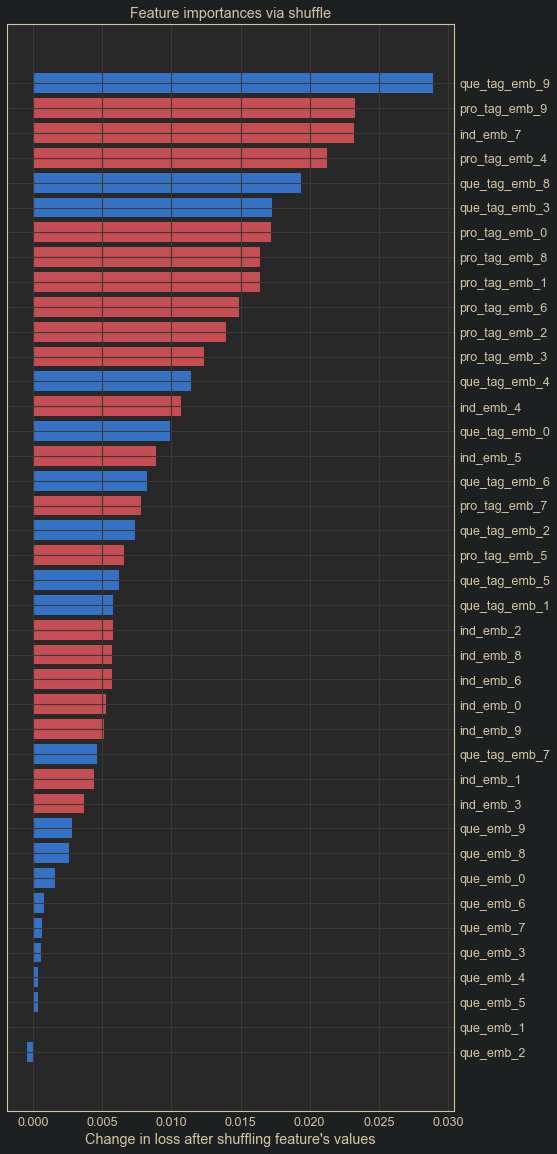

In [156]:
evaluating.plot_fi(fi, fn)

In [157]:
fi = evaluating.permutation_importance(model, test_batch_generator[0][0][0], test_batch_generator[0][0][1], test_batch_generator[0][1], fn)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 68us/step


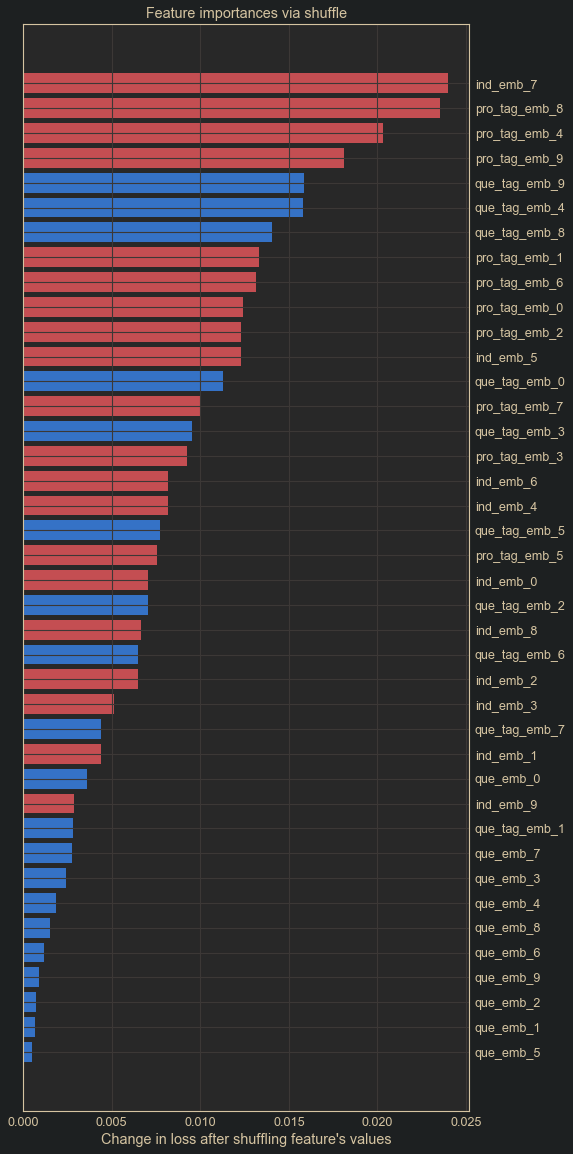

In [158]:
evaluating.plot_fi(fi, fn)